In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

In [4]:
database_name = 'processed_telecom'
table_name= 'xdr_data'

connection_params = { "host": "localhost", "user": "postgres", "password": "00000000",
                    "port": "5432", "database": database_name}

engine = create_engine(f"postgresql+psycopg2://{connection_params['user']}:{connection_params['password']}@{connection_params['host']}:{connection_params['port']}/{connection_params['database']}")

# str or SQLAlchemy Selectable (select or text object)
sql_query = 'SELECT * FROM xdr_data '

df = pd.read_sql(sql_query, con= engine)

In [5]:
# Aggregate the metrics per customer ID (MSISDN) and report the top 10 customers per engagement metric
engagement_metrics = df.groupby('MSISDN/Number').agg({
    'Dur. (ms)': 'sum',
    'Total UL (Bytes)': 'sum',
    'Total DL (Bytes)': 'sum'
}).reset_index()

top_10_customers_dur = engagement_metrics.sort_values(by='Dur. (ms)', ascending=False).head(10)
top_10_customers_ul = engagement_metrics.sort_values(by='Total UL (Bytes)', ascending=False).head(10)
top_10_customers_dl = engagement_metrics.sort_values(by='Total DL (Bytes)', ascending=False).head(10)


In [6]:
# Normalize the engagement metrics
scaler = StandardScaler()
engagement_metrics_normalized = scaler.fit_transform(engagement_metrics.drop(columns='MSISDN/Number'))


In [7]:
# Run k-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(engagement_metrics_normalized)


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [8]:
# Add cluster labels to the dataframe
engagement_metrics['Cluster'] = clusters


In [20]:
# Compute minimum, maximum, average, and total non-normalized metrics for each cluster
cluster_stats = engagement_metrics.groupby('Cluster').agg({
    'Dur. (ms)': ['min', 'max', 'mean', 'sum'],
    'Total UL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Total DL (Bytes)': ['min', 'max', 'mean', 'sum']
})


In [ ]:

# Visualize the results
plt.figure(figsize=(12, 6))
sns.barplot(x='Cluster', y='sum', data=cluster_stats['Dur. (ms)'], palette='coolwarm')
plt.title('Total Duration per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Duration (ms)')
plt.show()

In [11]:
# Aggregate user total traffic per application and derive the top 10 most engaged users per application
traffic_per_app = df.groupby('MSISDN/Number')[['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)',
                                                'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)',
                                                'Other DL (Bytes)', 'Social Media UL (Bytes)', 'Google UL (Bytes)',
                                                'Email UL (Bytes)', 'Youtube UL (Bytes)', 'Netflix UL (Bytes)',
                                                'Gaming UL (Bytes)', 'Other UL (Bytes)']].sum()


In [12]:

# Compute total traffic per user
traffic_per_user = traffic_per_app.sum(axis=1)

In [17]:
# Get top 10 most engaged users per application
top_10_users_per_app = {}
for col in traffic_per_app.columns:
    top_10_users_per_app[col] = traffic_per_app[col].nlargest(10)

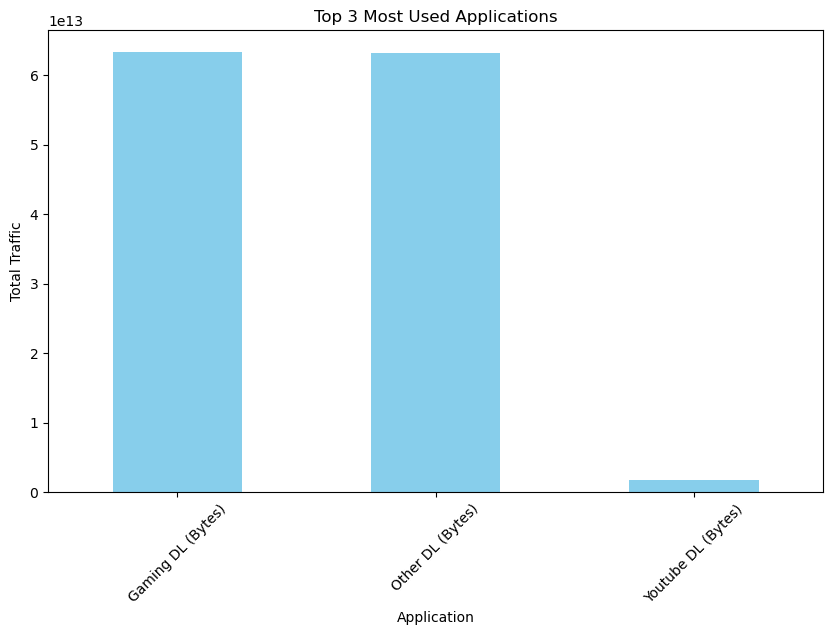

In [14]:
# Plot the top 3 most used applications
top_3_apps = traffic_per_app.sum().nlargest(3)
plt.figure(figsize=(10, 6))
top_3_apps.plot(kind='bar', color='skyblue')
plt.title('Top 3 Most Used Applications')
plt.xlabel('Application')
plt.ylabel('Total Traffic')
plt.xticks(rotation=45)
plt.show()

In [15]:
# Use the k-means clustering algorithm to group users into k engagement clusters
# Determine the optimized value of k using the elbow method
distortions = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(engagement_metrics_normalized)
    distortions.append(kmeans.inertia_)

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_k

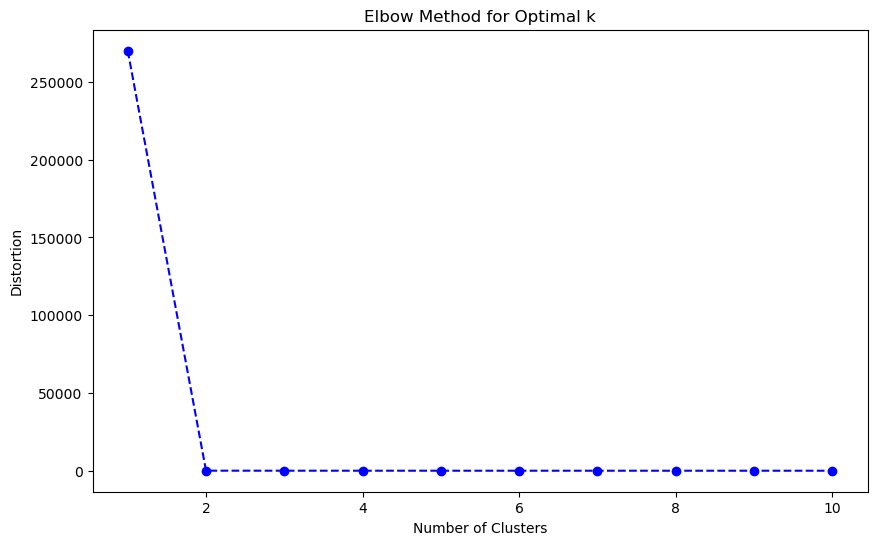

In [16]:
# Plot the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), distortions, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()